https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook 

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/#3-building-a-recurrent-neural-network-with-pytorch-gpu

In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [55]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [56]:
# check if we speed up computation by using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

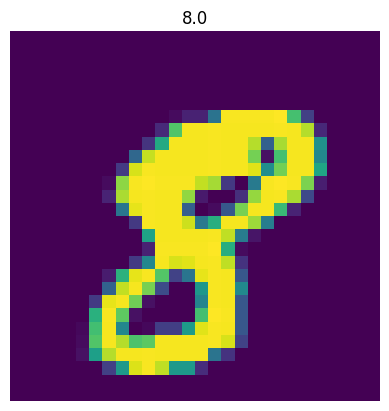

In [57]:
# Prepare Dataset
# load data
train = pd.read_csv(r"input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [58]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        """
        nn.RNN inputs: input_size, hidden_size, num_layers, nonlinearity, bias, batch_first, dropout, bidirectional
        """
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        """
        For batches, h0 should be of shape (N,L,H_in)
        N = batch size
        L = sequence length
        H_in = input_size
        """
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
            
        # One time step
        out, hn = self.rnn(x, h0.detach())
        # print(out[0,:,0])
        out = self.fc(out[:, -1, :]) # only care about the final output making this a multi input, single output RNN
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN

""" 
Based on their input dimensions, what makes this a recurrent neural network is the fact that the input dimenions
is only 28 but each image is 28x28. Thus for a single image, it is a sequence of length 28, each input being a size of 28
"""

input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

model.to(device) # send to gpu

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [59]:
temp = torch.from_numpy(features_numpy[10]).view(-1, 28, 28)
print("new shape: {}".format(temp.shape))

new shape: torch.Size([1, 28, 28])


In [60]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim)).requires_grad_().to(device)
        labels = Variable(labels).to(device)
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                # print(labels.shape)
                # print(train.shape)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 2.109966993331909  Accuracy: 25.39285659790039 %


KeyboardInterrupt: 

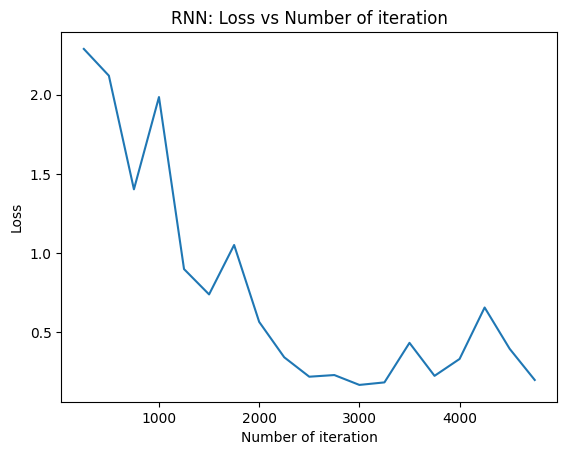

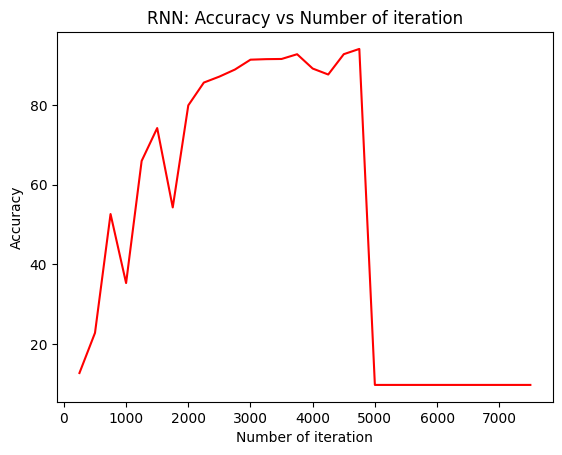

In [ ]:
# visualization loss 
loss_list = [loss.cpu() for loss in loss_list]
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

In [ ]:
import hub
ds = hub.load("hub://activeloop/spoken_mnist")

hub://activeloop/spoken_mnist loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



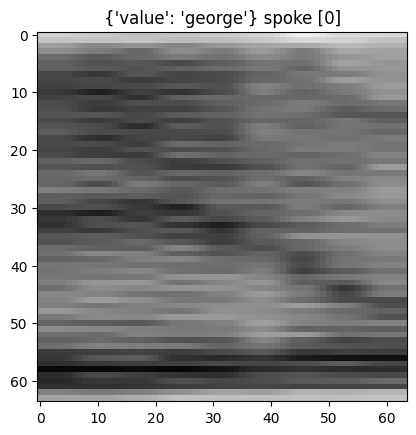

total audios: 3000
(2384,)


In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
from scipy import signal
import numpy as np
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
plt.imshow(ds.spectrograms[0].numpy())
plt.title(f"{ds.speakers[0].data()} spoke {ds.labels[0].numpy()}")
plt.show()

print("total audios: {}".format(len(ds.audio)))

a = ds.audio[0].numpy().T[0]
print(a.shape)
fs = 8000
Audio(a, rate=fs)
# fs, music = wavfile.read()

/home/jorgejc2/.local/lib/python3.8/site-packages/deeplake/core/tensor.py:622: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


(12, 3)


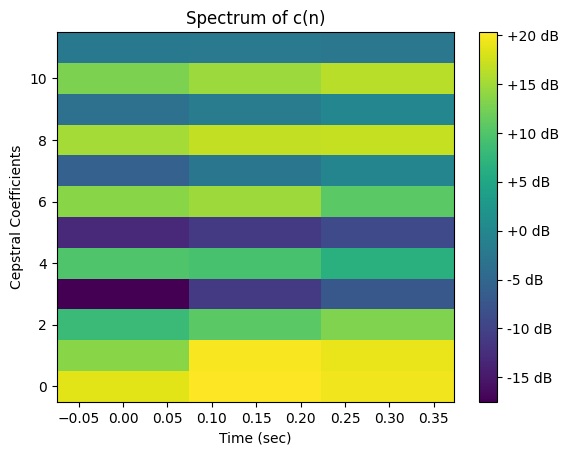

In [ ]:
nfft = 512
noverlap = -1
nfilt = 40
num_ceps = 13
t_time = len(a) / fs
min_frames = -1
max_frames = -1
max_frames_idx = 0
for i in range(len(ds.audio)-1000):
    a = ds.audio[i].numpy().T[0]
    ceps = np.array(myMatrix.MFCC_Matrix(list(a), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
    ceps = ceps[1:,:]
    t = np.linspace(0, t_time, ceps.shape[1])
    n = np.arange(num_ceps-1)
    if min_frames == -1 or ceps.shape[1] < min_frames:
        min_frames = ceps.shape[1]
    if max_frames == -1 or ceps.shape[1] > max_frames:
        max_frames = ceps.shape[1]
        max_frames_idx = i

print(ceps.shape)

plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, ceps)
plt.colorbar(format="%+2.f dB")

3
40
1047


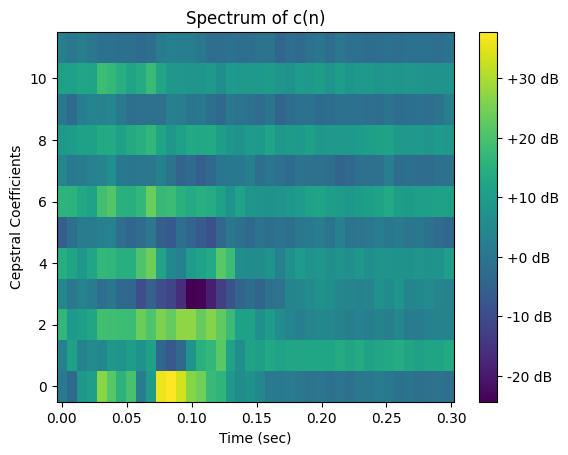

In [ ]:
print(min_frames)
print(max_frames)
print(max_frames_idx)
a = ds.audio[max_frames_idx].numpy().T[0]
ceps = np.array(myMatrix.MFCC_Matrix(list(a), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
ceps = ceps[1:,:]
t = np.linspace(0, t_time, ceps.shape[1])
n = np.arange(num_ceps-1)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, ceps)
plt.colorbar(format="%+2.f dB")

Audio(a, rate=fs)

#### Digit Recognizer

Testing a neural network for digit recognition for future reference

In [ ]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
# from utils import get_dataset_from_arrays
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random

In [ ]:
# Check if GPU is available
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu" # FORCE to run on cpu for simpler debugging

In [ ]:
"""
Process and organize data
"""
fs = 8000
nfft = 512
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_cols = 48
nn_data_rows = 12

ratio = 0.8
train_set_size = int(len(ds.audio) * ratio)
dev_set_size = int(len(ds.audio) * (1 - ratio))

# initialize arrays to hold processed data
l_train_set = []
l_train_labels = []
l_dev_set = []
l_dev_set_labels = []

# randomize access into audio files
random.seed(9001)
randomized_data = random.sample(range(len(ds.audio)), len(ds.audio))
train_indices = randomized_data[:train_set_size]
dev_indices = randomized_data[train_set_size:]

for i in range(train_set_size):
    curr_data_idx = train_indices[i]
    sig = ds.audio[curr_data_idx].numpy().T[0]
    l_train_set.append(np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel())
    l_train_labels.append(ds.labels[curr_data_idx].numpy()[0])

for i in range(dev_set_size):
    curr_data_idx = dev_indices[i]
    sig = ds.audio[curr_data_idx].numpy().T[0]
    l_dev_set.append(np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel())
    l_dev_set_labels.append(ds.labels[curr_data_idx].numpy()[0])

train_set = np.zeros((train_set_size,nn_data_rows*nn_data_cols))
dev_set = np.zeros((dev_set_size,nn_data_rows*nn_data_cols))
l_train_labels = np.array(l_train_labels, dtype=np.int64)
l_dev_set_labels = np.array(l_dev_set_labels, dtype=np.int64)

# append zeros or trim data in order to fulfull nn_data_cols requirement
for i in range(len(l_train_set)):
    curr_sig = l_train_set[i]
    if len(curr_sig) > nn_data_cols*nn_data_rows:
        train_set[i] = curr_sig[:nn_data_cols*nn_data_rows]
    elif len(curr_sig) < nn_data_cols*nn_data_rows:
        train_set[i] = np.resize(curr_sig, (nn_data_rows, nn_data_cols)).ravel()
    else:
        train_set[i] = curr_sig

for i in range(len(l_dev_set)):
    curr_sig = l_dev_set[i]
    if len(curr_sig) > nn_data_cols*nn_data_rows:
        dev_set[i] = curr_sig[:nn_data_cols*nn_data_rows]
    elif len(curr_sig) < nn_data_cols*nn_data_rows:
        dev_set[i] = np.resize(curr_sig, (nn_data_rows, nn_data_cols)).ravel()
    else:
        dev_set[i] = curr_sig




(2400,)
[6 0 7 0 6 6 5 6 3 3 5 5 7 5 2 3 3 4 2 3 9 4 8 4 7 7 4 2 1 4 4 3 1 3 8 6 9
 7 8 0 2 1 6 5 9 3 5 6 6 6 8 9 9 2 6 3 8 9 6 0 1 3 0 0 2 8 3 7 9 3 0 9 2 5
 2 9 5 7 8 5 0 5 4 6 2 4 2 5 9 0 0 7 5 3 0 5 6 4 1 8 1 5 0 6 8 9 3 5 1 2 8
 9 1 6 3 4 7 1 3 5 8 6 4 7 6 1 5 2 9 7 3 3 0 7 2 5 1 6 3 8 6 5 7 2 0 8 1 1
 4 2 8 4 1 6 7 7 8 2 0 0 0 2 1 2 1 6 3 0 1 7 3 1 4 0 3 1 8 7 5 2 3 8 6 0 4
 1 5 0 1 9 6 2 0 7 5 5 1 6 2 9 1 5 2 4 5 6 6 8 7 4 9 6 9 2 8 6 0 1 5 0 7 8
 8 9 0 9 8 4 3 0 5 6 4 6 7 0 9 9 1 9 0 2 3 0 5 1 1 2 6 2 7 6 1 1 6 7 0 1 6
 2 9 4 0 9 5 7 2 2 7 1 3 3 4 5 4 4 4 2 1 0 3 1 9 6 6 8 6 4 1 8 7 3 3 9 5 0
 6 0 3 8 4 1 7 7 8 9 7 0 5 0 7 0 6 7 4 8 8 5 9 7 9 2 8 1 4 5 6 7 0 3 5 8 8
 3 9 4 9 5 5 6 1 2 8 3 1 7 1 9 5 2 4 4 1 2 1 2 5 9 8 0 9 6 7 5 3 5 5 3 4 6
 7 1 2 1 2 0 0 7 5 6 4 9 1 0 5 2 4 2 1 2 1 2 0 9 1 9 8 5 2 0 8 8 8 8 3 0 3
 4 3 2 6 2 0 1 0 6 9 4 0 3 6 3 6 6 3 9 2 7 1 9 3 7 4 3 5 1 5 6 7 2 7 3 8 2
 3 0 8 6 0 3 3 2 4 3 7 3 2 1 1 1 7 4 2 4 5 5 0 5 6 2 5 3 5 1 8 9 3 9 2 9 4
 5 8 0 1 0 1 3 4 

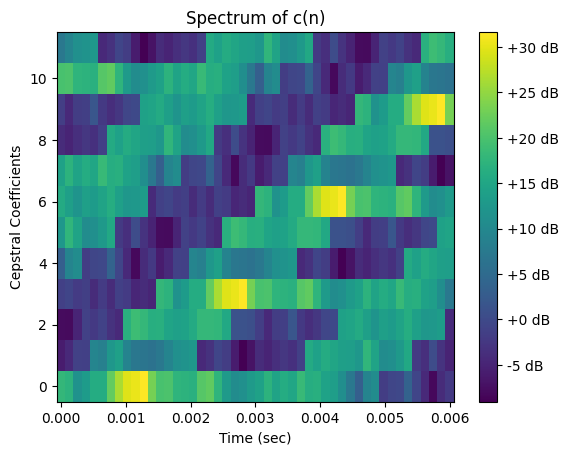

In [ ]:
"""
Run this block to check some of the outputs from the block above
"""
check_output = True
if check_output:
    print(l_train_labels.shape)
    print(l_dev_set_labels)

    t_time = nn_data_cols / fs
    data = np.resize(train_set[0],(nn_data_rows, nn_data_cols))
    t = np.linspace(0, t_time, nn_data_cols)
    n = np.arange(nn_data_rows)
    plt.title("Spectrum of c(n)")
    plt.ylabel("Cepstral Coefficients")
    plt.xlabel("Time (sec)")
    plt.pcolormesh(t, n, data)
    plt.colorbar(format="%+2.f dB")

In [ ]:
def compute_accuracies(predicted_labels, dev_set, dev_labels):
    yhats = predicted_labels
    # np.int was deprecated in latest versions
    # assert predicted_labels.dtype == np.int, "Your predicted labels have type {}, but they should have type np.int (consider using .astype(int) on your output)".format(predicted_labels.dtype)
    assert predicted_labels.dtype == int, "Your predicted labels have type {}, but they should have type np.int (consider using .astype(int) on your output)".format(predicted_labels.dtype)

    if len(yhats) != len(dev_labels):
        print("Lengths of predicted labels don't match length of actual labels", len(yhats), len(dev_labels))
        return 0., 0., 0., 0.
    accuracy = np.mean(yhats == dev_labels)
    conf_m = np.zeros((len(np.unique(dev_labels)),len(np.unique(dev_labels))))
    for i,j in zip(dev_labels,predicted_labels):
        conf_m[i,j] +=1

    return accuracy, conf_m

def get_parameter_counts(net):
    """ Get the parameters of your network
    @return params: a list of tensors containing all parameters of the network
            num_params: count of the total number of parameters
    """
    params = net.parameters()
    num_parameters = sum([ np.prod(w.shape) for w  in params])

    return num_parameters,params

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X,y):
        """
        Args:
            X [np.array]: features vector
            y [np.array]: labels vector          
        """
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = self.data[idx,:]
        label = self.labels[idx]
        sample = {'features': features,'labels': label}
        return sample

class NeuralNet(nn.Module):
    def __init__(self, lrate, in_size, out_size, mfcc_dim, loss_fn=nn.CrossEntropyLoss()):
        """
        Initializes the layers of your neural network.

        @param lrate: learning rate for the model
        @param loss_fn: A loss function defined as follows:
            @param yhat - an (N,out_size) Tensor
            @param y - an (N,) Tensor
            @return l(x,y) an () Tensor that is the mean loss
        @param in_size: input dimension
        @param out_size: output dimension

        For Part 1 the network should have the following architecture (in terms of hidden units):

        in_size -> h ->  out_size , where  1 <= h <= 256
        
        We recommend setting lrate to 0.01 for part 1.

        """
        super(NeuralNet, self).__init__()
        # define layers for music classification 
        self.mfcc_dim = mfcc_dim

        kernel_size = (3,3)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernel_size, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=kernel_size, stride=1, padding=1)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.16)
        self.dropout_3 = nn.Dropout(p=0.12)
        self.relu = nn.ReLU()

        self.model = nn.Sequential(self.conv1, nn.ReLU6(), self.maxpool, self.conv2, nn.ReLU6(), self.maxpool, self.dropout_1)


        self.linear_1 = nn.Linear(in_features=mfcc_dim[0]*mfcc_dim[1], out_features=300)
        self.linear_2 = nn.Linear(in_features=300, out_features=200)
        self.linear_3 = nn.Linear(in_features=200, out_features=out_size)

        # self.model_2 = nn.Sequential(self.linear_1, self.dropout_2, self.linear_2, self.dropout_3, self.linear_3)

        self.loss_fn = loss_fn
        self.double()

        self.optimizer = optim.SGD(self.parameters(), lr=lrate, weight_decay=1e-5)

    def conv_out_size(self, inp_size, kernel_size, dilation, padding, stride):
        return ((inp_size + 2*padding - dilation * (kernel_size - 1) - 1) // stride) + 1
    

    def forward(self, x):
        """Performs a forward pass through your neural net (evaluates f(x)).

        @param x: an (N, in_size) Tensor
        @return y: an (N, out_size) Tensor of output from the network
        """
        x = x.view(x.shape[0], 1, self.mfcc_dim[0], self.mfcc_dim[1])
        x = self.model(x)
        x = x.view(x.shape[0], self.mfcc_dim[0]*self.mfcc_dim[1])
        # x = self.model_2(x)
        # print("shape x before l1: {}".format(x.shape))
        x = self.linear_1(x)
        x = self.dropout_2(x)
        # print("shape x before l2: {}".format(x.shape))
        x = self.linear_2(x)
        x = self.dropout_3(x)
        # print("shape x before l3: {}".format(x.shape))
        x = self.linear_3(x)

        return x

    def step(self, x,y):
        """
        Performs one gradient step through a batch of data x with labels y.

        @param x: an (N, in_size) Tensor
        @param y: an (N,) Tensor
        @return L: total empirical risk (mean of losses) for this batch as a float (scalar)
        """
        # raise NotImplementedError("You need to write this part!")

        # zero out the optimizer
        self.optimizer.zero_grad()

        # pass the batch through the model
        y_hat = self.forward(x)
        # compute the lost
        loss = self.loss_fn(y_hat, y)

        # update model
        loss.backward()
        self.optimizer.step()

        return loss.item()
        return loss.detach().cpu().numpy()



def fit(in_size, out_size,train_set,train_labels,dev_set,epochs,batch_size=100):
    """ Make NeuralNet object 'net' and use net.step() to train a neural net
    and net(x) to evaluate the neural net.

    @param train_set: an (N, in_size) Tensor
    @param train_labels: an (N,) Tensor
    @param dev_set: an (M,) Tensor
    @param epochs: an int, the number of epochs of training
    @param batch_size: size of each batch to train on. (default 100)

    This method _must_ work for arbitrary M and N.

    The model's performance could be sensitive to the choice of learning rate.
    We recommend trying different values in case your first choice does not seem to work well.

    @return losses: list of floats containing the total loss at the beginning and after each epoch.
            Ensure that len(losses) == epochs.
    @return yhats: an (M,) NumPy array of binary labels for dev_set
    @return net: a NeuralNet object
    """
    # raise NotImplementedError("You need to write this part!")
    # print(len(train_labels))
    # print(train_set)
    # print(train_labels)
    # print(dev_set)
    
    u = train_set.mean()
    a = train_set.std()

    norm_set = (train_set-u)/a
    norm_dev = (dev_set-u)/a
    # data = MyDataset(norm_set, train_labels)
    data = MyDataset(train_set, train_labels)
    data = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False)

    # lrate, in_size, out_size, mfcc_dim, loss_fn=nn.CrossEntropyLoss()
    NetObject = NeuralNet(0.01, in_size, out_size, mfcc_dim=(12,48), loss_fn=nn.CrossEntropyLoss())

    losses = []
    for epoch in range(epochs):
        print("\rEpoch {}".format(epoch), end="")
        epoch_loss = 0.0
        for batch in data:
            batch_x, batch_y = batch
            # print("batch x size: {}".format(batch[batch_x].dtype))
            # print("batch y size: {}".format(batch[batch_y].dtype))
            epoch_loss += NetObject.step(batch[batch_x], batch[batch_y])
        epoch_loss /= len(data)

        losses.append(epoch_loss)

    ytemp = np.zeros((len(dev_set), out_size))
    with torch.no_grad():
        # ytemp = NetObject.forward(norm_dev).detach().cpu().numpy()
        ytemp = NetObject.forward(dev_set).detach().cpu().numpy()
        # for i in range(len(dev_set)):
        #     # dev = dev_set[i]
        #     dev = norm_dev[i]
        #     dev = Variable(dev.view(-1, seq_dim, in_size)).requires_grad_().to(device)
        #     ret_val = NetObject.forward(dev).detach().numpy()
        #     # print(ret_val)
        #     ytemp[i] = ret_val
        
    # print(ytemp)
    
    predicted_labels = []
    for i in range(len(ytemp)):
        idx = np.argmax(ytemp[i]).astype(int)
        predicted_labels.append(idx)

    predicted_labels = np.array(predicted_labels)
        
    return losses,predicted_labels,NetObject

In [ ]:
batch_size = 100
epochs = 2
input_dim = 12 # num ceps - 1
output_dim = 10 # number of genres

# convert numpys to torches
train_set = torch.tensor(train_set, dtype=torch.float64)
train_labels = torch.tensor(l_train_labels, dtype=torch.int64)
dev_set = torch.tensor(dev_set, dtype=torch.float64)
# dev_set_labels = torch.tensor(dev_set_labels)

In [ ]:
# fit data
# in_size, out_size,train_set,train_labels,dev_set,epochs,batch_size=100
L, predicted_labels, net = fit(input_dim, output_dim, train_set,train_labels,dev_set,epochs,batch_size)

assert type(predicted_labels) == np.ndarray, "your fit function returned the predicted labels as {} instead of np.ndarray. Make sure to use .detach().cpu().numpy() on the network output - and don't forget to argmax it!".format(type(predicted_labels))
assert type(L) == list,"your fit function returned the losses as {} instead of list. Make sure you are returning a list of losses (with length equal to the number of epochs)".format(type(L))

accuracy, conf_m = compute_accuracies(predicted_labels, dev_set, l_dev_set_labels)

print("\n Accuracy:", accuracy)
print("\nConfusion Matrix = \n {}".format(conf_m))
num_parameters,params = get_parameter_counts(net)
print('\nparameters = {} \n'.format(num_parameters))

/tmp/ipykernel_22765/4305363.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set = torch.tensor(train_set, dtype=torch.float64)
/tmp/ipykernel_22765/4305363.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dev_set = torch.tensor(dev_set, dtype=torch.float64)


Epoch 499
 Accuracy: 0.5943238731218697

Confusion Matrix = 
 [[36.  7.  5.  2.  4.  3.  2.  1.  0.  4.]
 [ 3. 42.  1.  0.  6.  1.  0.  1.  0. 10.]
 [ 2.  3. 36.  6.  7.  0.  1.  3.  5.  1.]
 [ 3.  1.  4. 32.  1.  1.  2.  6.  8.  7.]
 [ 4.  2.  1.  0. 41.  0.  2.  2.  1.  2.]
 [ 2.  5.  0.  1.  5. 38.  1.  5.  0.  3.]
 [ 1.  2.  3.  7.  0.  4. 37.  1.  8.  1.]
 [ 7.  1.  3.  2.  3.  4.  5. 24.  3.  1.]
 [ 3.  0.  5.  8.  2.  0.  3.  1. 33.  0.]
 [ 0.  8.  2.  1.  0.  0.  3.  3.  1. 37.]]

parameters = 235463 



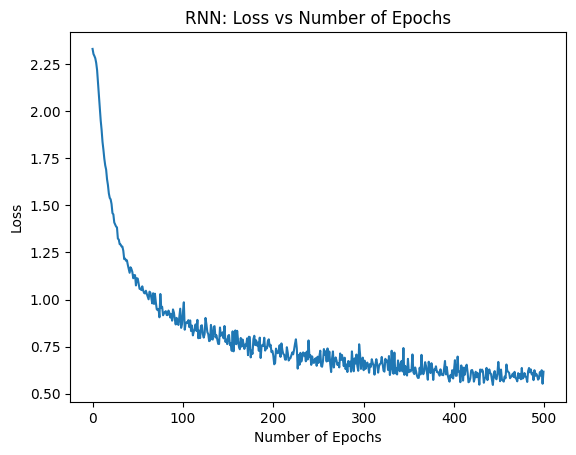

In [ ]:
iterations = [i for i in range(epochs)]
plt.plot(iterations, L)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of Epochs")
plt.show()

In [ ]:
# saving a model
# torch.save(net.state_dict(),'second_model_run.pth')

In [ ]:
# # loading the pytorch model
net = NeuralNet(0.01, input_dim, output_dim, mfcc_dim=(12,48), loss_fn=nn.CrossEntropyLoss())
net.load_state_dict(torch.load('second_model_run.pth'))
net.eval()

NeuralNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_1): Dropout(p=0.1, inplace=False)
  (dropout_2): Dropout(p=0.16, inplace=False)
  (dropout_3): Dropout(p=0.12, inplace=False)
  (relu): ReLU()
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU6()
    (5): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (linear_1): Linear(in_features=576, out_features=300, bias=True)
  (linear_2): Linear(in_features=300, out_features=200, bias=True)
  (linear_3): Linear(in_features=2

In [70]:
fs, music_stereo = wavfile.read('seven_voice_test.wav') # Import the sound file
print(fs)
Audio(music_stereo, rate=fs)

8000


In [71]:
ceps = np.array(myMatrix.MFCC_Matrix(list(music_stereo), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
ceps = ceps[1:,:]
processed_wav = ceps.ravel()
# fix dimensions if necessary
if len(processed_wav) > nn_data_cols*nn_data_rows:
        processed_wav = processed_wav[:nn_data_cols*nn_data_rows]
elif len(processed_wav) < nn_data_cols*nn_data_rows:
    processed_wav = np.resize(processed_wav, (nn_data_rows, nn_data_cols)).ravel()
# create data array for spectogram
data = np.resize(processed_wav, (nn_data_rows, nn_data_cols))
# turn to tensor
test_file = np.zeros((1, nn_data_cols*nn_data_rows))
test_file[0] = processed_wav
test_file = torch.tensor(test_file, dtype=torch.float64)
# check prediction
u = train_set.mean()
a = train_set.std()
test_file = (test_file-u)/a
result = net.forward(test_file).detach().cpu().numpy()
print(np.argmax(result).astype(int))

3


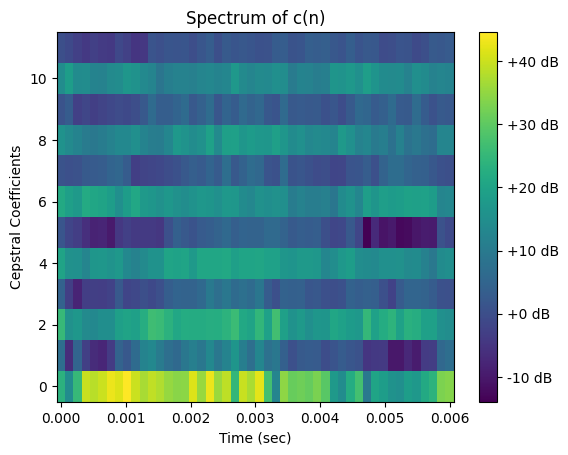

In [72]:
t_time = nn_data_cols / fs
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")